In [5]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

import random
import os

In [6]:
def seed_everything(seed: int = 1):
    random.seed(seed) #random과 관련된 함수 고정
    np.random.seed(seed) #np.random과 관련된 함수 고정
    torch.manual_seed(seed) #torch.rand(), torch.randint() 등 함수 고정
    os.environ['PYTHONHASHSEEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed = 1    
seed_everything(seed)

In [7]:
#데이터 읽어오기
orig_train = pd.read_csv("open/train.csv")
orig_test = pd.read_csv("open/test.csv")
sample_submission = pd.read_csv("open/sample_submission.csv")

In [8]:
#1. 데이터셋 정제 함수 정의(SNP data)
def get_x_y(df):
    if 'class' in df.columns:
        df_temp = df.drop(columns=['id'])
        df_temp = df_temp.drop_duplicates()
        df_temp = df_temp.reset_index(drop=True)
        df_y = df_temp['class']
        df_x = df_temp.drop(columns=['class'])
        return df_x, df_y, df_temp
    else:
        df_x = df.drop(columns=['id'])
        return df_x

In [9]:
train_x_snp, train_y, df_temp = get_x_y(orig_train)
test_x_snp = get_x_y(orig_test)

In [10]:
#snp data 및 target 레이블 인코딩
class_le = preprocessing.LabelEncoder()
snp_le = preprocessing.LabelEncoder()

snp_col = [f'SNP_{str(x).zfill(2)}' for x in range(1,16)]
snp_data = []
for col in snp_col:
    snp_data += list(train_x_snp[col].values)
    
snp_le.fit(snp_data) #fit
for col in train_x_snp.columns:
    if col in snp_col:
        train_x_snp[col] = snp_le.transform(train_x_snp[col]) #transform
        test_x_snp[col] = snp_le.transform(test_x_snp[col]) #transform

train_y = class_le.fit_transform(train_y) #target 레이블 fit_transform

In [11]:
#Min-Max Scaling
#Standard Scaling
scaler = preprocessing.StandardScaler()
scaler_fit = scaler.fit(train_x_snp) #fit
train_x_snp_s = scaler.transform(train_x_snp) #transform
train_x_snp_s = pd.DataFrame(train_x_snp_s, columns = train_x_snp.columns)
test_x_snp_s = pd.DataFrame(scaler.transform(test_x_snp), columns = test_x_snp.columns) #transform

In [12]:
train_x_snp_s

,father,mother,gender,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
0,0.0,0.0,0.0,0.577350,0.900166,-0.631247,-1.044036,0.776520,0.303032,-0.959796,-0.754385,0.938318,-0.638759,0.831894,-0.434662,-0.935775,-1.154190,-0.614729,-1.163452
1,0.0,0.0,0.0,0.577350,-0.910777,-0.631247,0.595677,-1.051425,-1.296476,-0.460390,-0.754385,0.467319,-0.638759,-0.996130,-0.910190,0.862037,1.136295,-0.614729,-1.163452
2,0.0,0.0,0.0,0.577350,0.900166,1.210340,-1.044036,0.776520,1.102786,1.537234,-0.754385,0.467319,1.398903,-0.996130,-0.910190,-0.935775,-1.154190,-0.614729,-1.163452
3,0.0,0.0,0.0,-1.732051,-1.363513,1.210340,-1.044036,0.776520,-1.296476,1.537234,1.533797,-1.416677,1.908319,-0.996130,1.467449,1.311489,1.136295,-0.614729,1.134725
4,0.0,0.0,0.0,0.577350,0.900166,1.210340,1.415533,-1.051425,1.102786,-0.959796,-0.754385,-1.416677,-0.638759,0.831894,-0.910190,-0.935775,-0.696093,-0.614729,0.675089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.0,0.0,0.0,0.577350,-0.910777,-0.631247,-1.044036,0.776520,1.102786,-0.460390,-0.754385,0.467319,-0.638759,0.831894,-0.434662,0.862037,-1.154190,-0.614729,-1.163452
252,0.0,0.0,0.0,0.577350,0.900166,-1.091644,0.595677,-1.051425,-1.296476,-0.460390,1.076161,0.467319,-0.638759,-0.996130,-0.434662,-0.935775,-0.696093,-0.614729,0.675089
253,0.0,0.0,0.0,-1.732051,-0.910777,1.210340,-1.044036,0.776520,-1.296476,-0.460390,1.533797,0.467319,1.398903,-1.453136,1.467449,1.311489,1.136295,1.258731,1.134725
254,0.0,0.0,0.0,-1.732051,-1.363513,1.210340,-1.044036,0.776520,-1.296476,1.537234,1.533797,-1.416677,1.398903,-0.996130,-0.434662,0.862037,1.136295,1.258731,1.134725


In [13]:
sixteen_train = train_x_snp_s.copy()
sixteen_test = test_x_snp_s.copy()

In [14]:
sixteen_train = sixteen_train.drop(columns=['father', 'mother', 'gender'])
sixteen_test = sixteen_test.drop(columns=['father', 'mother', 'gender'])

In [15]:
sixteen_test

,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
0,-1.732051,-0.910777,1.210340,-1.044036,0.776520,-1.296476,-0.460390,1.533797,0.467319,1.398903,-0.996130,-0.434662,0.862037,1.136295,1.258731,0.675089
1,0.577350,0.900166,-0.631247,1.415533,1.233506,1.102786,-0.959796,-0.754385,-1.416677,-0.638759,0.831894,-0.434662,-0.935775,-1.154190,-0.614729,-1.163452
2,0.577350,0.900166,-0.631247,-1.044036,-1.051425,0.303032,-0.460390,-0.754385,-1.416677,-0.638759,-0.996130,-0.910190,0.862037,1.136295,-0.614729,1.134725
3,0.577350,0.900166,-0.631247,0.595677,-1.051425,1.102786,-0.959796,-0.754385,-1.416677,-0.638759,0.831894,-0.910190,0.862037,-0.696093,-0.614729,-1.163452
4,-1.732051,-1.363513,1.210340,-1.044036,1.233506,-1.296476,1.537234,1.533797,-1.416677,1.908319,-0.996130,1.467449,0.862037,1.136295,-0.614729,1.134725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0.577350,-0.910777,1.210340,1.415533,-1.051425,0.303032,-0.460390,-0.754385,0.938318,-0.638759,0.831894,1.467449,-0.935775,-1.154190,-0.614729,0.675089
171,0.577350,0.900166,-1.091644,-1.044036,-1.051425,0.303032,-0.460390,-0.754385,-1.416677,-0.638759,-0.996130,-0.910190,-0.935775,-0.696093,-0.614729,0.675089
172,0.577350,0.900166,-1.091644,-1.044036,-1.051425,0.303032,-0.460390,-0.754385,-1.416677,-0.638759,0.831894,-0.434662,-0.935775,-0.696093,-0.614729,1.134725
173,0.577350,-0.910777,1.210340,0.595677,0.776520,1.102786,1.537234,-0.754385,0.467319,-0.638759,0.831894,-0.434662,-0.935775,-1.154190,-0.614729,-1.163452


In [16]:
#torch.tensor형으로 만들기
sixteen_input_x = torch.tensor(sixteen_train.values, dtype = torch.float32)
sixteen_input_x_test = torch.tensor(sixteen_test.values, dtype = torch.float32)
train_y_target = torch.tensor(train_y, dtype=torch.int64)

## K-fold 

In [17]:
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

## Dataset

In [18]:
train_data = torch.utils.data.TensorDataset(sixteen_input_x, train_y_target)
test_data = sixteen_input_x_test    

## Define the Network

In [86]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,8)
        self.fc3 = nn.Linear(8,3)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = x.view(-1, 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x        

In [97]:
model = Net()

In [98]:
model

Net(
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

## Loss Function and Optimizer 

In [100]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

## Learning Rate Scheduler 

In [27]:
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                              lr_lambda=lambda epoch: 0.9**epoch,
                                              last_epoch=-1,
                                              verbose=False) #초기 learning rate에 lambda함수에서 나온 값을 곱해서 lr 계산
# epoch을 거듭할수록 lr을 낮춰줌


## Early Stopping 사용

In [31]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0.0001, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss
        self.early_stop = False
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model) #가장 작은 valid_loss가 나왔을 때 호출함
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                self.counter = 0
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model) #가장 작은 valid_loss가 나왔을 때 호출함
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## 모델 학습 

In [101]:
def train_model(model, batch_size, patience, n_epochs):

    # 모델이 학습되는 동안 trainning loss를 track
    train_losses = []
    # 모델이 학습되는 동안 validation loss를 track
    valid_losses = []
    # epoch당 average training loss를 track
    avg_train_losses = []
    # epoch당 average validation loss를 track
    avg_valid_losses = []


    # early_stopping object의 초기화
    early_stopping = EarlyStopping(patience = patience, verbose = True)
    
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(train_data)):
        
    
        print(f'Fold {fold} out of {kfold.n_splits}')

        
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_idx)
        
        #sampler를 이용한 DataLoader 정의
        train_loader = torch.utils.data.DataLoader(train_data, 
                                                   batch_size=batch_size, 
                                                   sampler = train_subsampler)
        
        valid_loader = torch.utils.data.DataLoader(train_data, 
                                                   batch_size=batch_size, 
                                                   sampler = valid_subsampler)
        
    
        for epoch in range(1, n_epochs + 1):

            ###################
            # train the model #
            ###################
            model.train() # prep model for training
            for batch, (data, target) in enumerate(train_loader, 1): #enumerate(인덱스 1부터 시작한다는 뜻 start=1)
                # clear the gradients of all optimized variables
                optimizer.zero_grad()    
                # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
                output = model(data)
                # calculate the loss
                loss = criterion(output, target)
                # backward pass: 모델의 파라미터와 관련된 loss의 그래디언트 계산
                loss.backward()
                # perform a single optimization step (parameter update)
                optimizer.step()
                scheduler.step()
                # record training loss
                train_losses.append(loss.item())


            ######################    
            # validate the model #
            ######################
            model.eval() # prep model for evaluation
            for data , target in valid_loader :
                # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
                output = model(data)
                # calculate the loss
                loss = criterion(output, target)
                # record validation loss
                valid_losses.append(loss.item())

            # print 학습/검증 statistics
            # epoch당 평균 loss 계산
            train_loss = np.average(train_losses)
            valid_loss = np.average(valid_losses)
            avg_train_losses.append(train_loss)
            avg_valid_losses.append(valid_loss)

            epoch_len = len(str(n_epochs))


            print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                         f'train_loss: {train_loss:.5f} ' +
                         f'valid_loss: {valid_loss:.5f}')

            #파이썬 포맷팅 - 길이와 정렬 - {:>길이}는 오른쪽정렬 의미
        
            print(print_msg)

            # clear lists to track next epoch
            train_losses = []
            valid_losses = []

            # early_stopping은 epoch 1회 마다 validation loss가 감소하였는지 확인이 필요하며,
            # 만약 감소하였을경우 현재 모델을 checkpoint로 만든다.
            early_stopping(valid_loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                break #만약 early stop 조건이 충족되면 break 후 다음 fold로 넘어감

    # best model이 저장되어있는 last checkpoint를 로드한다.
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses #epoch 당 평균 loss를 리턴함


batch_size = 16
n_epochs = 100

# early stopping patience;
# validation loss가 개선된 마지막 epoch 이후로 얼마나 기다릴지 지정
patience = 30

model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs)   

Fold 0 out of 5
[  1/100] train_loss: 0.57683 valid_loss: 0.17819
Validation loss decreased (inf --> 0.178191).  Saving model ...
[  2/100] train_loss: 0.21990 valid_loss: 0.18013
EarlyStopping counter: 1 out of 30
[  3/100] train_loss: 0.27647 valid_loss: 0.15817
Validation loss decreased (0.178191 --> 0.158169).  Saving model ...
[  4/100] train_loss: 0.55834 valid_loss: 0.33797
EarlyStopping counter: 1 out of 30
[  5/100] train_loss: 0.23267 valid_loss: 0.15849
EarlyStopping counter: 2 out of 30
[  6/100] train_loss: 0.29466 valid_loss: 0.22347
EarlyStopping counter: 3 out of 30
[  7/100] train_loss: 0.35158 valid_loss: 0.21673
EarlyStopping counter: 4 out of 30
[  8/100] train_loss: 0.31978 valid_loss: 0.24254
EarlyStopping counter: 5 out of 30
[  9/100] train_loss: 0.20322 valid_loss: 0.17546
EarlyStopping counter: 6 out of 30
[ 10/100] train_loss: 0.18166 valid_loss: 0.16668
EarlyStopping counter: 7 out of 30
[ 11/100] train_loss: 0.17130 valid_loss: 0.24084
EarlyStopping counter

[ 63/100] train_loss: 0.15453 valid_loss: 0.19422
EarlyStopping counter: 26 out of 30
[ 64/100] train_loss: 0.10291 valid_loss: 0.14530
EarlyStopping counter: 27 out of 30
[ 65/100] train_loss: 0.13899 valid_loss: 0.23877
EarlyStopping counter: 28 out of 30
[ 66/100] train_loss: 0.14093 valid_loss: 0.26413
EarlyStopping counter: 29 out of 30
[ 67/100] train_loss: 0.15246 valid_loss: 0.27108
EarlyStopping counter: 30 out of 30
Early stopping
Fold 2 out of 5
[  1/100] train_loss: 0.24067 valid_loss: 0.06909
EarlyStopping counter: 1 out of 30
[  2/100] train_loss: 0.13217 valid_loss: 0.06182
EarlyStopping counter: 2 out of 30
[  3/100] train_loss: 0.15184 valid_loss: 0.14381
EarlyStopping counter: 3 out of 30
[  4/100] train_loss: 0.15327 valid_loss: 0.04961
EarlyStopping counter: 4 out of 30
[  5/100] train_loss: 0.08968 valid_loss: 0.05339
EarlyStopping counter: 5 out of 30
[  6/100] train_loss: 0.16133 valid_loss: 0.11646
EarlyStopping counter: 6 out of 30
[  7/100] train_loss: 0.11937

[  1/100] train_loss: 0.14289 valid_loss: 0.02954
EarlyStopping counter: 1 out of 30
[  2/100] train_loss: 0.11981 valid_loss: 0.10377
EarlyStopping counter: 2 out of 30
[  3/100] train_loss: 0.19528 valid_loss: 0.03779
EarlyStopping counter: 3 out of 30
[  4/100] train_loss: 0.13065 valid_loss: 0.03594
EarlyStopping counter: 4 out of 30
[  5/100] train_loss: 0.15122 valid_loss: 0.03008
EarlyStopping counter: 5 out of 30
[  6/100] train_loss: 0.13851 valid_loss: 0.02592
EarlyStopping counter: 6 out of 30
[  7/100] train_loss: 0.17550 valid_loss: 0.00938
EarlyStopping counter: 7 out of 30
[  8/100] train_loss: 0.12068 valid_loss: 0.00766
EarlyStopping counter: 8 out of 30
[  9/100] train_loss: 0.11980 valid_loss: 0.01077
EarlyStopping counter: 9 out of 30
[ 10/100] train_loss: 0.18107 valid_loss: 0.02884
EarlyStopping counter: 10 out of 30
[ 11/100] train_loss: 0.14319 valid_loss: 0.03869
EarlyStopping counter: 11 out of 30
[ 12/100] train_loss: 0.09608 valid_loss: 0.01501
EarlyStopping

## Visualizing Loss 

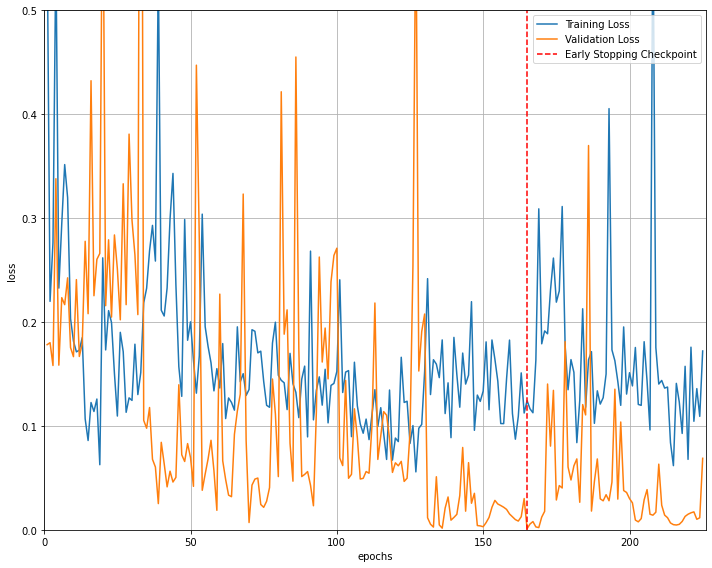

In [102]:
#모델 과적합 직접 Early Stopping Checkpoint가 저장됨
# 훈련이 진행되는 과정에 따라 loss를 시각화
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # 일정한 scale
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

## Inference 

In [103]:
result1 = [np.argmax(i) for i in model(sixteen_input_x_test).detach().numpy()] #detach()로 tensor만 추출 후 array로 변환
sample_submission['class'] = class_le.inverse_transform(result1)
sample_submission

,id,class
0,TEST_000,A
1,TEST_001,B
2,TEST_002,C
3,TEST_003,C
4,TEST_004,A
...,...,...
170,TEST_170,B
171,TEST_171,C
172,TEST_172,C
173,TEST_173,B


In [104]:
sample_submission['class'].value_counts()

B    86
A    51
C    38
Name: class, dtype: int64

In [ ]:
#lr, epoch&patience, dropout, batch-size

In [111]:
sample_submission.to_csv('v5_.csv', index=False)